# Classification
In this notebook you will go through a classification problem.

Unlike the previous lecture, where we dealt with a regression problem, 
this time you are going to predict a categorical value, i.e., a class.

# Setup


In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import pickle

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
DATA_DIR = os.path.join(PROJECT_ROOT_DIR,'data')
IMG_DIR = os.path.join(PROJECT_ROOT_DIR, 'img')
CHAPTER_ID = "classification"


def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

## MNIST
MNIST is likely the most famous dataset in ML.

It is a collection of 70.000 handwritten digits. 

Each image is associated with its actual digit.

`sklearn` provides some helper function to fetch this dataset.

**Warning**: `fetch_mldata()` is deprecated since Scikit-Learn 0.20. You should use `fetch_openml()` instead. However, it returns the unsorted MNIST dataset, whereas `fetch_mldata()` returned the dataset sorted by target (the training set and the test test were sorted separately). In general, this is fine, but if you want to get the exact same results as before, you need to sort the dataset using the following function:

In [2]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data.iloc[reorder_train]
    mnist.target[:60000] = mnist.target.iloc[reorder_train]
    mnist.data[60000:] = mnist.data.iloc[reorder_test + 60000]
    mnist.target[60000:] = mnist.target.iloc[reorder_test + 60000]

In [3]:
def maybe_download_mnist():
    if not os.path.isdir(DATA_DIR):
        os.mkdir(DATA_DIR)
    download = False
    if not os.listdir(DATA_DIR):
        download = True
        # empty directory download the file
        try:
            from sklearn.datasets import fetch_openml
            mnist = fetch_openml('mnist_784', version=1, cache=True)
            mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
            sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
        except ImportError:
            from sklearn.datasets import fetch_mldata
            mnist = fetch_mldata('MNIST original')
    mode = 'wb' if download else 'rb'
    with open(os.path.join(DATA_DIR,'mnist.pickle'), mode) as f:
        if download:
            pickle.dump(mnist, f)
        else:
            mnist = pickle.load(f)
    return mnist
mnist = maybe_download_mnist()


The object you just downloaded has a dict-like structure.

The actual data are stored in the ``.data`` field of the object.


In [5]:
print([k for k in mnist])

['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url']


Take a look at the shape of your dataset. 


In [8]:
mnist.data.shape

(70000, 784)

In [9]:
X, y = mnist["data"].values, mnist["target"].values
X.shape

(70000, 784)

In [12]:
y.shape

(70000,)

In [13]:
28*28

784

There are 70.000 images with 784 features. 
Each feature represents the density of a pixel, ranging from 0 to 255.

Each row is the rollout vector of a 28x28 image.

You can plot some data by reshaping the vector into the original matrix and then you
can use ``matplotlib.imshow``.

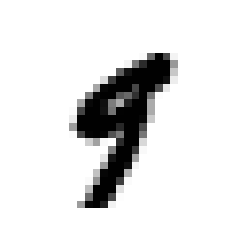

In [14]:
some_digit = X[36000]

def draw(sample, save_path = None):
    some_digit_image = some_digit.reshape(28, 28)
    plt.imshow(some_digit_image, cmap = mpl.cm.binary,
           interpolation="nearest")
    plt.axis("off")
    if save_path is not None:
        save_fig(os.path.join(IMG_DIR, save_path))

draw(some_digit)

In [15]:

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

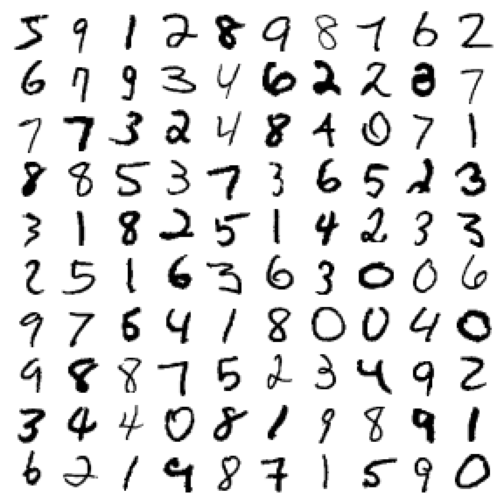

In [16]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
plt.show()

Now let's split the data

In [17]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=1/7, random_state=42 )
X_train.shape


(60000, 784)

# Training a Binary Classifier

Before diving into the details of the problem,
let's focus on slightly simpler sub-problem. 

You have to train a _binary classifier_.

The label _5__ is regarded as the positive class.

Let's create the new target vector for this problem.

In [19]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

some_digit = X[36000]


Let's pick the **Stochastic Gradient Descent** classifier and train it upon the 
new dataset.

The main advantage of this classifier is its ability to handle large datasets in a very efficient way.


In [22]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(max_iter=5, random_state=42, tol=-inf)

array([False])

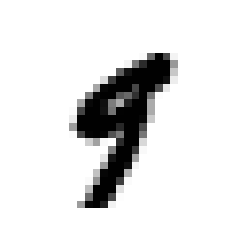

In [23]:
draw(some_digit)
sgd_clf.predict([some_digit])

## Performance Measures for Classification Problem.

When we introduced the regression problem we discussed about two commonly
used performance measures: RMSE, MAE.

**Question**: Are they useful in this context?

*Answer*: 

----

## Measuring Accuracy with Cross-Validation
Accuracy is defined as the ratio of 
the number of correct predictions on the total number of predictions. 

More formally:

$$
ACCURACY = \frac{\#\: right predictions}{\#\: predictions}
$$

### Implementing Cross-Validation
Occasionally you will need more control over the cross-validation process than what
``cross_val_score`` and similar functions provide.

In these cases, you can implement
cross-validation yourself; it is actually fairly straightforward.

The ``StratifiedKFold`` class performs stratified sampling 
to produce folds that contain a representative ratio of each class. 

Every iteration of the following code involves the following steps:

    1. Create a clone of the classifier
    2. Train the classifier against the training folds
    3. Compute predicitons over the validation fold 


In [24]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# stratified splitting of the training samples
skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.96095
0.96775
0.9201


If your are lazy, just go with sklearn:

In [25]:
from sklearn.model_selection import cross_val_score
cross_val_scores = cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")
cross_val_scores.max()

0.96775

More than 90%! It is great, isn't it?

**Question**: Should we be satisfied with this result?

Let's implement another classifier.  A dummy classifier that always predict
``False``.

In [26]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [28]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9119 , 0.90875, 0.91055])

In [30]:
y_train_5.sum()/y_train_5.shape[0] # perc. di istanze positive

0.0896

**Question**: What's just happened?

Accuracy is often a misleading metric,
especially when data are skewed.

## Confusion Matrix

A much better way to evaluate the performance of a classifier is to look at the confusion matrix.

The general idea is to count the number of times instances of class A are
classified as class B.

The confusion matrix can be computed with function ``confusion_matrix`` of
``sklearn.metrics``.

First you need to compute some predictions.

In [31]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [32]:
def display_cofusion_matrix(matrix, classes):
    s = "\t"+"\t".join(classes)
    for i, row in enumerate(matrix):
        s += "\n{}\t{}".format(classes[i], "\t".join([str(x) for x in row]))
    return s

from sklearn.metrics import confusion_matrix
print(f"Ground Truth:{y_train_5.sum()}, Predicted: {y_train_pred.sum()}")
print(display_cofusion_matrix(confusion_matrix(y_train_5, y_train_pred), ['not-5', '5']))

Ground Truth:5376, Predicted: 5802
	not-5	5
not-5	52899	1725
5	1299	4077


Each row represents the actual class while the column represents the predicted class.

Since we are dealing with binary classification, we can devise 4 categories:
* True Positive - samples predicted as positive that are actually positive (right classification)
* True Negative - samples predicted as negative that are actually negative (right classification)
* False Positive - samples predicted as positive that are actually negative (wrong classification)
* False Negative - samples predicted as negative that are actually positibe( wrong classification)



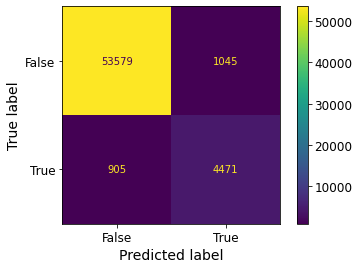

In [33]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(sgd_clf, X_train, y_train_5)


A perfect binary classifier would be the following

In [34]:
y_train_perfect_predictions = y_train_5

In [35]:
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54624,     0],
       [    0,  5376]])

## Precision and Recall
The confusion matrix is the building block for two other measures:

* Precision - it is given by: 
    $$PRECISION = \frac{TP}{TP+FP} = \frac{\text{# volte predizione positiva corretta}}{\text{# volte che il clas. pred. Positiva}}$$
    
    It measures how many times
    prediction of a positive sample were actually positive.
    
* Recall - it is given by: $$ RECALL = \frac{TP}{TP+FN} = \frac{\text{# volte predizione positiva corretta}}{\text{# istanze positive totali}}$$

    It measures how many positve samples are captured from the set of all the positive samples.
    
If we apply these measures over the trained classifier we get:

In [36]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.7026887280248191

In [37]:
recall_score(y_train_5, y_train_pred)

0.7583705357142857

See? The model is far from being perfect as the >90% precision suggested before.

Precision and recall, combined together, define the so called $F_1$ score denoted as:

$$
F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = 2 \times \frac{precision \times recall}{precision +  recall}
$$

The $F_1$ score favors classifiers that have similar precision and recall. 

**Question**: Are precision and recall equally important?

*Answer*....

**Question**: Is there any correlation between precision and recall?

*Answer*....


In [ ]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)


## Precision/Recall Trade-off

``SGDClassifier`` associates to each point a score, 
based on which it takes its final decision about the class of a sample.

In order to take this decision, sgd uses a threshold value. 
If the score of a sample exceeds this threshold then it is considered
a positive sample.


**Question** How, and to what degree, does the threshold impact on both precision and recall?

*Answer*

---
Let's see what happen when you increase or decrease the threshold.

With  the method ``decision_function`` you can access the score assigned to 
the sample given as input.

In [38]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-235001.42499422])

In [39]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [40]:
y_some_digit_pred

array([False])

You can try different values of threshold

In [42]:
threshold = -300000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

If you want to obtain scores instead of classes you can use set ``method="decision_function"``.


In [47]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")
y_scores.shape, y_scores

((60000,),
 array([-864514.84731334, -200505.57363537, -356455.35448005, ...,
         -37438.40146144, -234660.62644763, -402959.02594215]))

Setting manually a threshold is not a common approach.

A better way is to plot the precision recall curve.


In [44]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
print(precisions.shape, recalls.shape, thresholds.shape)


(59333,) (59333,) (59332,)


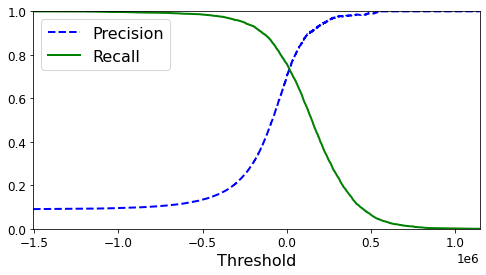

In [45]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([thresholds.min(), thresholds.max()])

plt.show()

In [46]:
thresholds.max()

1143409.4634532887

Based on this curve you can select the threshold that gives you the best 
precision/recall tradeoff.

Another way to select a good precision/recall tradeoff is to plot
precision directly against recall.

In [48]:
y_train_pred_90 = (y_scores > 70000)

In [49]:
precision_score(y_train_5, y_train_pred_90)

0.831224635951301

In [50]:
recall_score(y_train_5, y_train_pred_90)

0.6476934523809523

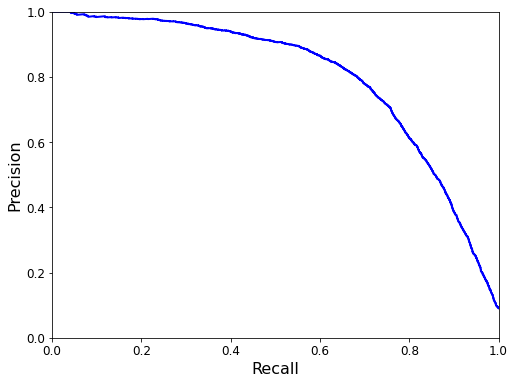

In [51]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)

plt.show()


__Take Home Lesson__

At this point you should be aware of the fact that accuracy is not the only metrics.

Clearly, having 90% precision is not useful if either recall or precision are too low.

## ROC curves
The receiver operating characteristic curve is another common tool used
with binary classifier.

The ROC curve shows the true-positive-rate (another name for Recall) against the false-positive-rate.

This second quantity, the  FPR, is the ratio of negative samples misclassified as positive.

Another quantity is the true-negative-rate, i.e., the ratio of negative samples correctly classified as negative (TNR)

The false positive rate can be computed as $FPR = 1-FNR$

The ROC curve combines all these information.

In short:

* True positive rate (recall/sensitivity)
    $$TPR = \frac{TP}{TP+FN}$$

* False positive rate 
    $$
        FPR = \frac{FP}{FP+TN} 
    $$
* True negative rate (specificity)
    $$
        TNR = \frac{TN}{TN+FP} 
    $$

To plot the ROC curve, you first need to compute the TPR and FPR for various threshold values, using the  ``roc_curve`` function.

The ROC curve plots *sensitivity* versus 1-*specificity*.

In [52]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

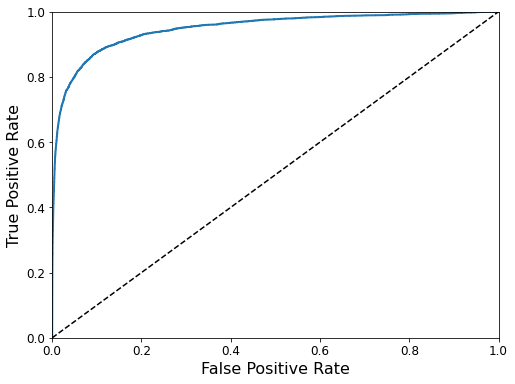

In [53]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

Again, the ROC curve highlights the negative correlation between precision and recall.

In fact, increasing  recall usually leads to decreasing accuracy.

The dotted line represents the ROC curve associated to a purely random classifier. 

The performance of a classifier are proportional to the distance between its 
ROC curve and the one related to the random classifiers.


One can directly measure the area under the ROC curve, that is called AUC.

It must be as closer as possible to one.

sklearn provides a function for computing this area.


In [54]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.948799341237804

### Review

You have seen a number of different ways for measuring the performance of a classifier. 

> How to choose the correct one?

There are general rule of thumbs.

Precision Recall comes in handy when the dataset is unbalanced, with few positive samples
as opposed to negative ones. Also, if you are more interested in keeping false positive low
rather than false negative.

In other situations, ROC/AUC is the way to go.

This result suggests that your model works pretty good. 

However, there is still room for improvement. 
In fact, performance are good because the dataset is strongly unbalanced towards the negative class.


**Exercise**

Train a ``RandomForestClassifier`` (Hint: pass ``predict_proba`` as the ``method`` argument).

Display the ROC curve, precision and recall.

In [55]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)

y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

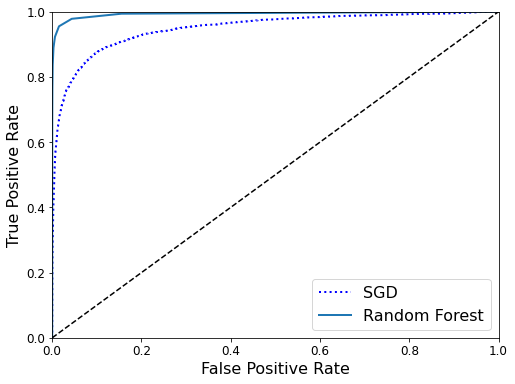

In [58]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD") # sgd_clf
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest") # forest_clf
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [59]:
roc_auc_score(y_train_5, y_scores_forest)

0.9933978918323884

# Multiclass classification
From this point on, we will address the original multiclass classification problem.


Instead of having to choose between only a pair of labels, you need to assign a label amongst a number
labels.

Many algorithms like the Random Forest Classifier
or the Naive Bayes Classifier are able to genuinely handle multiclass
classification problems.

However, other algorithm needs to be properly extended in order to 
embrace a multiclass classification problem.

The main strategy is to adapt their binary version.

Two approaches are:

    1. One vs All (OVA) - if you are asked to predict a class amongst N different ones, you can train N different binary classifiers. Each one of them is trained in order to detect a single class against all the others.
    
    2. One vs One (OVO) - given N different class, you can  N x (N-1)/2 different binary classifier. You will need to train a classifier for every possible pair of classes.

For most binary classification algorithms the OVA approach is the one adopted by default.

sklearn automatically detects when you need to solve a multiclass classification problem.


In [60]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([4], dtype=int8)

Actually, under the hood,
scikit-Learn actually trained 10 binary classifiers, it obtained their decision scores for the
image, and then it selected the class with the highest score.

To convince yourself about the actual strategy adopted by sklearn you can 
compute the scores associated with the ``some_digit``.

In [61]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-731402.01591867, -186030.71872914, -771032.74297674,
         -47888.1856048 ,   44138.57341642, -174440.22961558,
        -760194.29753324, -157459.54385885, -239005.20440822,
        -120007.48262189]])

Each score  **reflects** a probability, i.e., the likelihood the a certain sample belongs to 
the corresponding class.

The class is assigned computing the argmax on this vector of scores

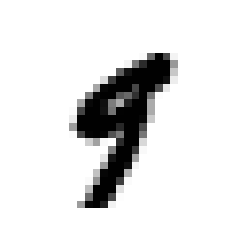

In [63]:
draw(some_digit)

In [64]:
np.argmax(some_digit_scores)


4

**Note**: Be careful, this 5 actually is the index of the maximum element, not the class!

The classes upon which the classifier is trained can be accessed via the ``classes_`` field of the estimator

In [65]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [66]:
sgd_clf.classes_[4]

4

You can force sklearn to adopt the OVO by wrapping a classifier with the
``OneVsOneClassifier`` .
You need to pass a regular binary classifier and then call the usual fit method.

In [67]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, tol=-np.infty, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])


array([4], dtype=int8)

In [68]:
len(ovo_clf.estimators_)

45

Now, try with a **RandomForestClassifier**

In [69]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([9], dtype=int8)

In [70]:
forest_clf.predict_proba([some_digit])

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [74]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy").mean()

0.8627666666666666

It gets over 84% on all test folds. 

A random classifier would get 10% accuracy, not a bad score.
But you can improve.

We did not use any preprocessing techniques yet.


In [75]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
p = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', sgd_clf)
])

cross_val_score(p, X_train, y_train, cv=3, scoring="accuracy").mean()


0.9105666666666666

**Exercise**: Modify the above cell to train the same classifier but after applying the `StandardScaler`



## Error Analysis
Let assume we found a promising model.

One thing to do is to evaluate its errors.

You need to make predictions using the ``cross_val_predict`` fnction and then
call the ``confusion_matrix()`` function, just like
you did earlier:

In [76]:
X_train_scaled = StandardScaler().fit_transform(X_train)
y_train_pred =  cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5736,    2,   24,   14,   10,   42,   46,   10,   34,    2],
       [   1, 6462,   41,   27,    5,   37,    8,   10,  125,    9],
       [  52,   34, 5374,  107,   87,   25,   80,   64,  181,   19],
       [  43,   26,  137, 5372,    5,  214,   35,   55,  127,   93],
       [  21,   28,   38,    6, 5467,    8,   56,   34,   68,  192],
       [  77,   33,   28,  184,   73, 4555,  118,   30,  174,  104],
       [  39,   26,   51,    1,   47,   88, 5595,    8,   60,    0],
       [  31,   25,   75,   29,   56,    7,    8, 5749,   19,  239],
       [  50,  129,   74,  164,   16,  161,   54,   17, 5030,  161],
       [  41,   30,   27,   90,  187,   40,    2,  178,   75, 5252]])

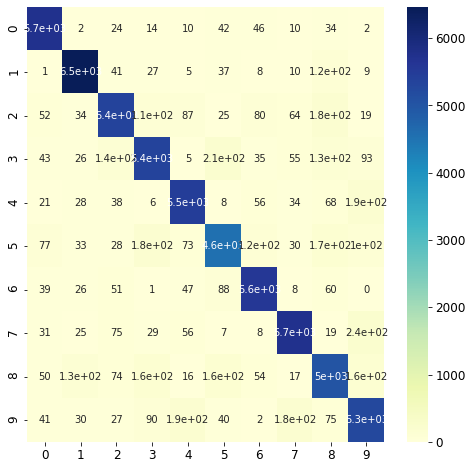

In [77]:
import seaborn as sns
def plot_confusion_matrix(matrix):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    sns.heatmap(matrix, 
                annot=True,  
                cmap="YlGnBu")
            
plot_confusion_matrix(conf_mx)

Let’s focus the plot on the errors. 

First, you need to divide each value in the confusion
matrix by the number of images in the corresponding class, so you can compare error
rates instead of absolute number of errors.


In [78]:
row_sums = conf_mx.sum(axis=1, keepdims=True) # num of samples for each class
col_sum = conf_mx.sum(axis=0, keepdims=True)  # num of predictions for each class
norm_conf_mx = conf_mx / row_sums


Now let’s fill the diagonal with zeros to keep only the errors, and plot the result:

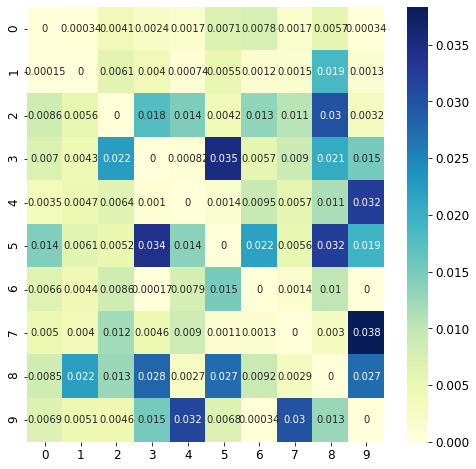

In [79]:
np.fill_diagonal(norm_conf_mx, 0)
plot_confusion_matrix(norm_conf_mx)

The columns corresponding to 8 and 9 are quite dark,
which tells you that many images get misclassified as 8s or 9s. 

Similarly, the rows for classes 8 and 9 are also quite dark, telling you that 8s
and 9s are often confused with other digits. 

Conversely, some rows are pretty bright,
such as ow 1: this means that most 1s are classified correctly.

# Multilabel classification

Until now each instance has always been assigned to just one class. In some cases you
may want your classifier to output multiple classes for each instance. For example,
consider a face-recognition classifier: what should it do if it recognizes several people
on the same picture?

Such a classification system that outputs multiple
binary labels is called a multilabel classification system.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

This code creates a y_multilabel array containing two target labels for each digit
image: the first indicates whether or not
the digit is large (7, 8, or 9) and the second
indicates whether or not it is odd. The next lines create a KNeighborsClassifier,
Now you can make a prediction, and notice
that it outputs two labels:

In [ ]:
knn_clf.predict([some_digit])

And it gets it right! The digit 5 is indeed not large ( False ) and odd ( True ).

There are many ways to evaluate a multilabel classifier, and selecting the right metric
really depends on your project. For example, one approach is to measure the F 1 score
for each individual label (or any other binary classifier metric discussed earlier), then
simply compute the average score. This code computes the average F 1 score across all
labels:

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

This assumes that all labels are equally important, which may not be the case.

One simple option is to give each label a weight equal to its support (i.e., the number of instances with that
target label). To do this, simply set average="weighted" in the preceding code.

# Exercises
Train different classifiers and test their performance on the test set

## KNN classifier

## SVM

# Decision Tree 

## Logistic Regression

## 1. An MNIST Classifier With Over 97% Accuracy

`KNeighborsClassifiers` seems to perform pretty well.

Let's try to push its performance with 
automated parameter tuning. 

The algorithm has just one parameter: k, which represents the n

## 2. Testing and Selecting the best Model
Now, you are required to build an entire pipeline. 
You need to select a number of models, tuning upon each of them and then you need to report in a table the following
information:

1. Name of The estimator
2. Best Configuration
3. accuracy
3. precision
4. recall
5. AUC score

Of course, these results must be obtained wrt the **VALIDATION SET**.